In [343]:
import pandas as pd
import numpy as np
from collections import Counter
import re,string

from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

In [307]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from wordcloud import WordCloud
from textwrap import wrap
import textstat

In [389]:
import spacy
import scattertext as st

In [366]:
data = pd.read_csv("./data/amazon1.csv")

In [367]:
data.shape

(34660, 21)

In [368]:
data.drop('id',axis=1,inplace=True)
data.drop('asins',axis=1,inplace=True)
data.drop('keys',axis=1,inplace=True)


data.drop('manufacturer',axis=1,inplace=True)
data.drop('reviews.id',axis=1,inplace=True)
data.drop('reviews.sourceURLs',axis=1,inplace=True)
data.drop('reviews.userCity',axis=1,inplace=True)
data.drop('reviews.userProvince',axis=1,inplace=True)
data.drop('reviews.didPurchase',axis=1,inplace=True)

data.drop('reviews.dateAdded',axis=1,inplace=True)
data.drop('reviews.dateSeen',axis=1,inplace=True)

In [369]:
data = data[~data['reviews.text'].isnull()]

In [370]:
data['reviews.text'][:10]

0    This product so far has not disappointed. My c...
1    great for beginner or experienced person. Boug...
2    Inexpensive tablet for him to use and learn on...
3    I've had my Fire HD 8 two weeks now and I love...
4    I bought this for my grand daughter when she c...
5    This amazon fire 8 inch tablet is the perfect ...
6    Great for e-reading on the go, nice and light ...
7    I gave this as a Christmas gift to my inlaws, ...
8    Great as a device to read books. I like that i...
9    I love ordering books and reading them with th...
Name: reviews.text, dtype: object

In [371]:
data.isnull().sum()

name                   6760
brand                     0
categories                0
reviews.date             39
reviews.doRecommend     593
reviews.numHelpful      528
reviews.rating           33
reviews.text              0
reviews.title             5
reviews.username          2
dtype: int64

In [372]:
data = data[~data['reviews.doRecommend'].isnull()]
data = data[~data['reviews.numHelpful'].isnull()]
data = data[~data['reviews.rating'].isnull()]

## Adding category id for easier visulization 

In [373]:
category_dict={}
for i,key in enumerate(dict(data['categories'].value_counts()).keys()):
    category_dict[key]=i

In [374]:
data['cat_id'] = data['categories'].apply(lambda category:category_dict[category])

In [375]:
data.dtypes

name                    object
brand                   object
categories              object
reviews.date            object
reviews.doRecommend     object
reviews.numHelpful     float64
reviews.rating         float64
reviews.text            object
reviews.title           object
reviews.username        object
cat_id                   int64
dtype: object

## Format Date

In [376]:
data['reviews.date'] = pd.to_datetime(data['reviews.date'])

In [377]:
data['reviews.month'] = data['reviews.date'].dt.month

In [378]:
data['reviews.year'] = data['reviews.date'].dt.year

## Encode Reviews.recommend

In [379]:
data['reviews.doRecommend'] = data['reviews.doRecommend'].apply(lambda t:1 if t==True else 0)

# Clean the text

## Expand Contractions

In [380]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [381]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

data['reviews.text']=data['reviews.text'].apply(lambda x:expand_contractions(x))

In [430]:
data['name'] = data['name'].astype('str')

In [431]:
data['name']=data['name'].apply(lambda x: x.split(',,,')[0])

## Change all text to lowecase

In [432]:
data['reviews.text']=data['reviews.text'].apply(lambda x: x.lower())

In [433]:
data.head()

,name,brand,categories,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,reviews.username,cat_id,reviews.month,reviews.year,polarity,review_len,word_count
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13 00:00:00+00:00,1,0.00,5.00,this product so far has not disappointed my ch...,Kindle,Adapter,4,1,2017,0.33,141,27
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13 00:00:00+00:00,1,0.00,5.00,great for beginner or experienced person bough...,very fast,truman,4,1,2017,0.80,74,14
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13 00:00:00+00:00,1,0.00,5.00,inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ,4,1,2017,0.60,125,26
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-13 00:00:00+00:00,1,0.00,4.00,i have had my fire hd two weeks now and i lov...,Good!!!,Shacks,4,1,2017,0.37,572,114
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",2017-01-12 00:00:00+00:00,1,0.00,5.00,i bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42,4,1,2017,0.37,601,116


In [384]:
def preprocess(reviewtext):
    reviewtext = reviewtext.str.replace("(<br/>)","")
    reviewtext = reviewtext.str.replace("\w*\d\w*","") # Digits & Word Containing digits
    reviewtext = reviewtext.str.replace("[%s]"%re.escape(string.punctuation),"") #Punctuations
    #reviewtext = reviewtext.str.replace(" +","") #Extra Spaces
    
    return reviewtext

data['reviews.text'] = preprocess(data['reviews.text'])

data['polarity']=data['reviews.text'].map(lambda text: TextBlob(text).sentiment.polarity)
data['review_len'] = data['reviews.text'].astype(str).apply(len)
data['word_count'] = data['reviews.text'].apply(lambda x: len(str(x).split()))

In [386]:
for index,text in enumerate(data['reviews.text'][30:35]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 if your looking for a affordable gift this is it
Review 2:
 this is a great tablet for the price would recommend it to anyone looking for a basic tablet
Review 3:
 works great love the portability of books overall great product
Review 4:
 i am still learning all the things i can do with my new kindle fire it is so much better lighter in weight and easier to use than my old tablet
Review 5:
 just the right size for reading books and playing some games


## Distribution of polarity

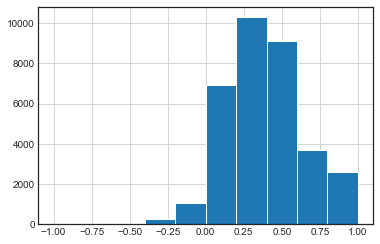

In [324]:
data["polarity"].hist()

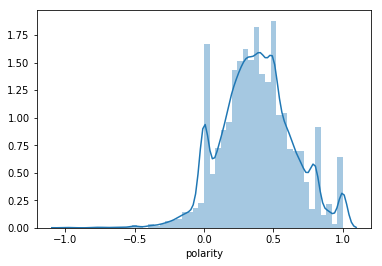

In [12]:
sns.distplot(data["polarity"],hist=True)

## Distribution of review rating

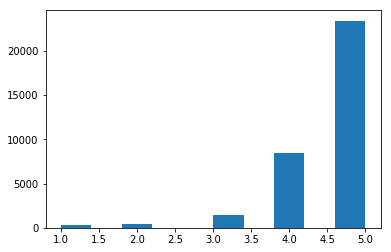

In [13]:
plt.hist(data['reviews.rating'])
plt.show()

## Distribution of review Length

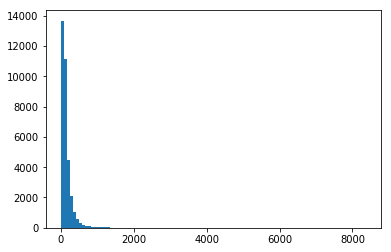

In [14]:

plt.hist(data['review_len'],bins=100)
plt.show()

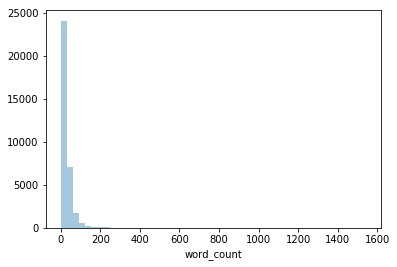

In [18]:
sns.distplot(data['word_count'],kde=False)


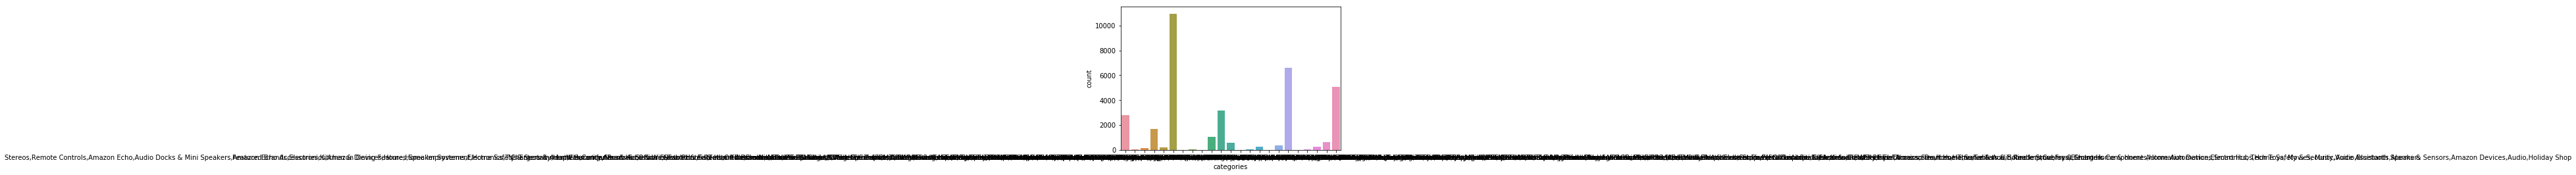

In [20]:
sns.countplot(data['categories'])
plt.show()

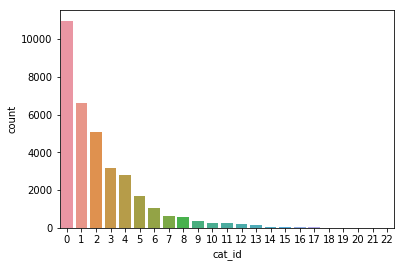

In [33]:
sns.countplot(data['cat_id'])
plt.show()

In [42]:
list(data.loc[data['cat_id']==0,'categories'][:1])

['Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys']

In [43]:
list(data.loc[data['cat_id']==1,'categories'][:1])

['Stereos,Remote Controls,Amazon Echo,Audio Docks & Mini Speakers,Amazon Echo Accessories,Kitchen & Dining Features,Speaker Systems,Electronics,TVs Entertainment,Clearance,Smart Hubs & Wireless Routers,Featured Brands,Wireless Speakers,Smart Home & Connected Living,Home Security,Kindle Store,Home Automation,Home, Garage & Office,Home,Voice-Enabled Smart Assistants,Virtual Assistant Speakers,Portable Audio & Headphones,Electronics Features,Amazon Device Accessories,iPod, Audio Player Accessories,Home & Furniture Clearance,Consumer Electronics,Smart Home,Surveillance,Home Improvement,Smart Home & Home Automation Devices,Smart Hubs,Home Safety & Security,Voice Assistants,Alarms & Sensors,Amazon Devices,Audio,Holiday Shop']

In [44]:
list(data.loc[data['cat_id']==2,'categories'][:1])

['Back To College,College Electronics,College Tvs & Home Theater,Electronics,Tvs & Home Theater,Streaming Devices,Featured Brands,Amazon Devices,Holiday Shop,Ways To Shop,TV & Home Theater,Streaming Media Players,All Streaming Media Players,TVs Entertainment,Video Games,Kindle Store,Electronics Features,Kids & Family,Fire TV']

## Distribution of month

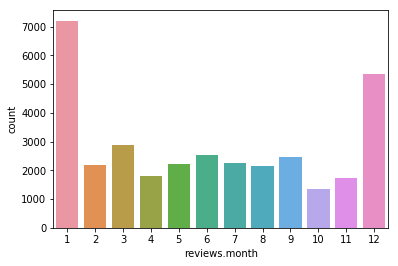

In [58]:
sns.countplot(data['reviews.month'])
plt.show()

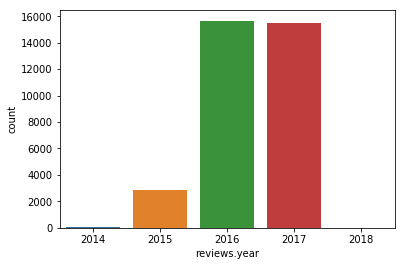

In [59]:
sns.countplot(data['reviews.year'])
plt.show()

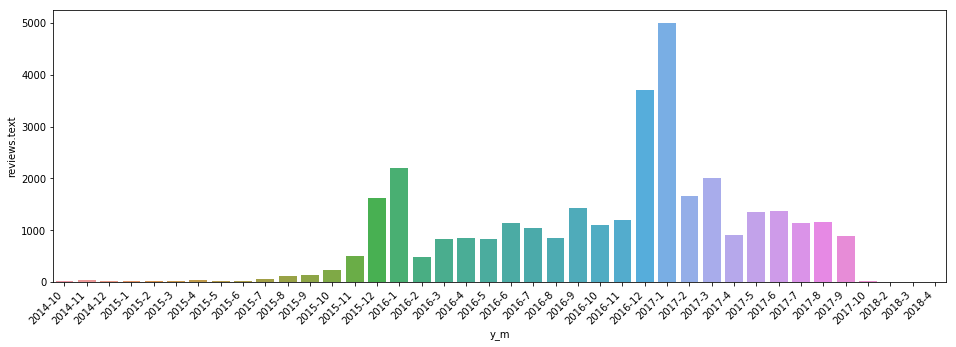

In [105]:
df_y_m=data.groupby(['reviews.year','reviews.month'])['reviews.text'].agg('count').reset_index()

df_y_m['y_m'] = df_y_m[['reviews.year','reviews.month']].astype(str).agg('-'.join, axis=1)

fig,ax =plt.subplots(figsize = (16,5))

fig = sns.barplot(x = "y_m", y = "reviews.text", data = df_y_m, 
                  estimator = sum, ci = None, ax=ax)

ax.set_xticklabels(labels=df_y_m['y_m'], rotation=45, ha='right')

plt.show()

## Distribution of top unigrams

In [149]:
def get_top_ngrams(df,n=None):
    vec = CountVectorizer().fit(df)
    
    bag_of_words = vec.transform(df)
    
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word,sum_words[0,i]) for word,i in vec.vocabulary_.items()]
    #words_freq = list(cv_fit.vocabulary_.items())
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse=True)
    
    return words_freq[:n]

In [150]:
common_words = get_top_ngrams(data['reviews.text'],25)

In [151]:
common_words

[('the', 42688),
 ('it', 34244),
 ('and', 33200),
 ('to', 32965),
 ('for', 25985),
 ('is', 20362),
 ('this', 17297),
 ('my', 16987),
 ('great', 11762),
 ('of', 10702),
 ('with', 9196),
 ('tablet', 9063),
 ('you', 8266),
 ('on', 8177),
 ('have', 7910),
 ('use', 7585),
 ('that', 7534),
 ('in', 6895),
 ('but', 6633),
 ('love', 6591),
 ('can', 6419),
 ('was', 6343),
 ('as', 6212),
 ('easy', 6176),
 ('so', 5946)]

In [122]:
df_ngram = pd.DataFrame(common_words,columns=['word','count'])
df_ngram = df_ngram.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()

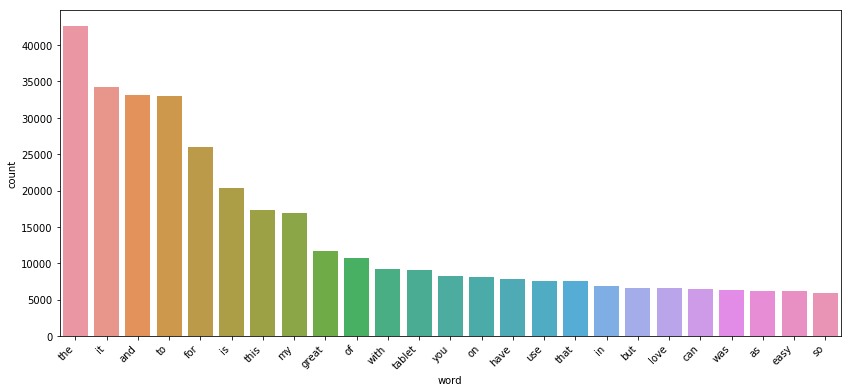

In [165]:
fig,ax = plt.subplots(figsize=(14,6))
fig = sns.barplot(x = 'word',y='count',data=df_ngram,ci = None, ax=ax)

ax.set_xticklabels(labels=df_ngram['word'], rotation=45, ha='right')
plt.show()

In [135]:
cv = CountVectorizer()
cv_fit = cv.fit(data['reviews.text'])
bow = cv_fit.transform(data['reviews.text'])

In [152]:
sow= bow.sum(axis=0)

In [171]:
cv.fit_transform(data['reviews.text'])

<34064x13529 sparse matrix of type '<class 'numpy.int64'>'
	with 798325 stored elements in Compressed Sparse Row format>

In [166]:
bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [156]:
sow[a]

matrix([[77,  5,  2, ...,  1,  2,  1]], dtype=int64)

## Distribution of top unigrams (after removing stop words)

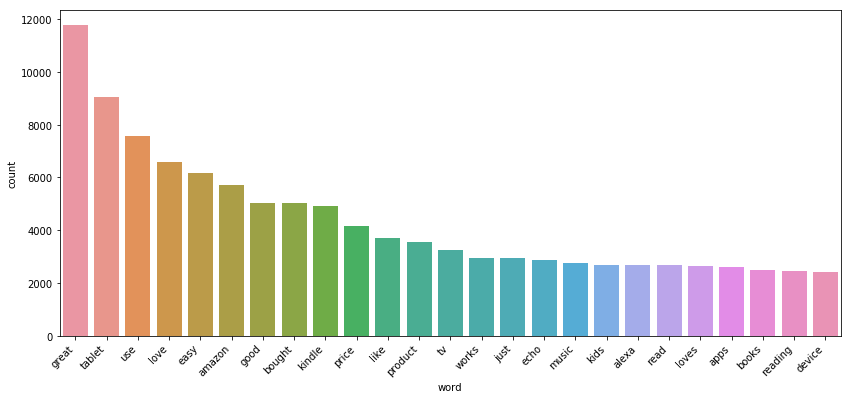

In [179]:
def get_top_ngrams(df,n=None):
    vec = CountVectorizer(stop_words='english').fit(df)
    
    bag_of_words = vec.transform(df)
    
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word,sum_words[0,i]) for word,i in vec.vocabulary_.items()]
    #words_freq = list(cv_fit.vocabulary_.items())
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse=True)
    
    return words_freq[:n]

common_words = get_top_ngrams(data['reviews.text'],25)

df_ngram = pd.DataFrame(common_words,columns=['word','count'])
df_ngram = df_ngram.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(14,6))
fig = sns.barplot(x = 'word',y='count',data=df_ngram,ci = None, ax=ax)

ax.set_xticklabels(labels=df_ngram['word'], rotation=45, ha='right')
plt.show()

## Distribution of top bigrams (after removing stop words)

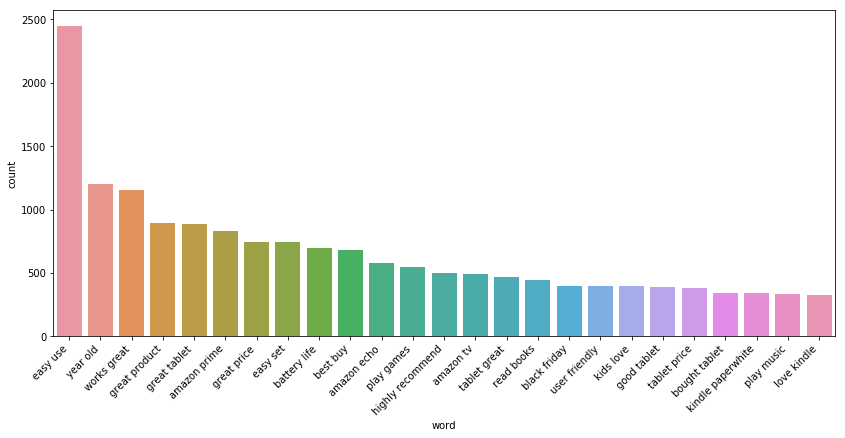

In [180]:
def get_top_ngrams(df,n=None):
    vec = CountVectorizer(ngram_range=(2,2), stop_words='english').fit(df)
    
    bag_of_words = vec.transform(df)
    
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word,sum_words[0,i]) for word,i in vec.vocabulary_.items()]
    #words_freq = list(cv_fit.vocabulary_.items())
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse=True)
    
    return words_freq[:n]

common_words = get_top_ngrams(data['reviews.text'],25)

df_ngram = pd.DataFrame(common_words,columns=['word','count'])
df_ngram = df_ngram.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(14,6))
fig = sns.barplot(x = 'word',y='count',data=df_ngram,ci = None, ax=ax)

ax.set_xticklabels(labels=df_ngram['word'], rotation=45, ha='right')
plt.show()

## Distribution of top trigrams (before removing stop words)

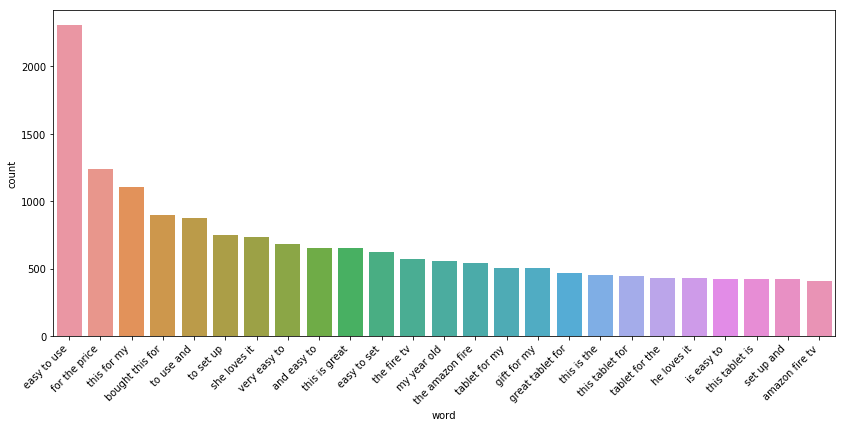

In [181]:
def get_top_ngrams(df,n=None):
    vec = CountVectorizer(ngram_range=(3,3)).fit(df)
    
    bag_of_words = vec.transform(df)
    
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word,sum_words[0,i]) for word,i in vec.vocabulary_.items()]
    #words_freq = list(cv_fit.vocabulary_.items())
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse=True)
    
    return words_freq[:n]

common_words = get_top_ngrams(data['reviews.text'],25)

df_ngram = pd.DataFrame(common_words,columns=['word','count'])
df_ngram = df_ngram.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(14,6))
fig = sns.barplot(x = 'word',y='count',data=df_ngram,ci = None, ax=ax)

ax.set_xticklabels(labels=df_ngram['word'], rotation=45, ha='right')
plt.show()

## Distribution of top trigrams (after removing stop words)

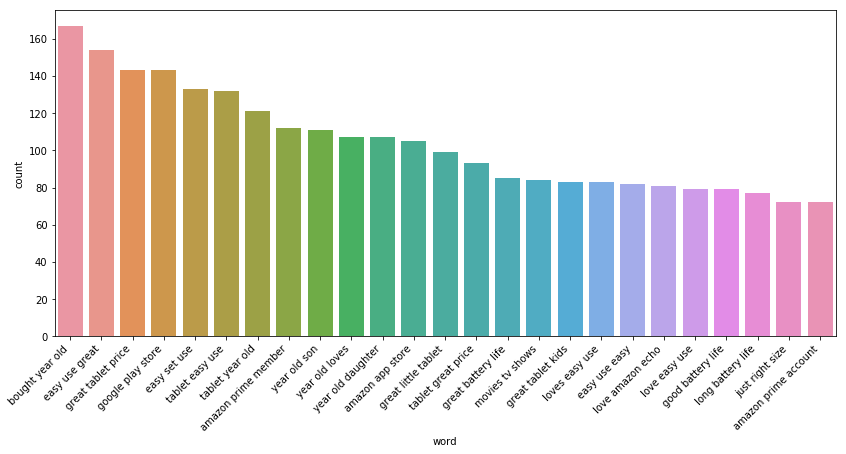

In [182]:
def get_top_ngrams(df,n=None):
    vec = CountVectorizer(ngram_range=(3,3), stop_words='english').fit(df)
    
    bag_of_words = vec.transform(df)
    
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word,sum_words[0,i]) for word,i in vec.vocabulary_.items()]
    #words_freq = list(cv_fit.vocabulary_.items())
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse=True)
    
    return words_freq[:n]

common_words = get_top_ngrams(data['reviews.text'],25)

df_ngram = pd.DataFrame(common_words,columns=['word','count'])
df_ngram = df_ngram.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(14,6))
fig = sns.barplot(x = 'word',y='count',data=df_ngram,ci = None, ax=ax)

ax.set_xticklabels(labels=df_ngram['word'], rotation=45, ha='right')
plt.show()

# POS tagging

## Ratings across Categories

In [219]:
df_cat = data[data['cat_id']<=10]


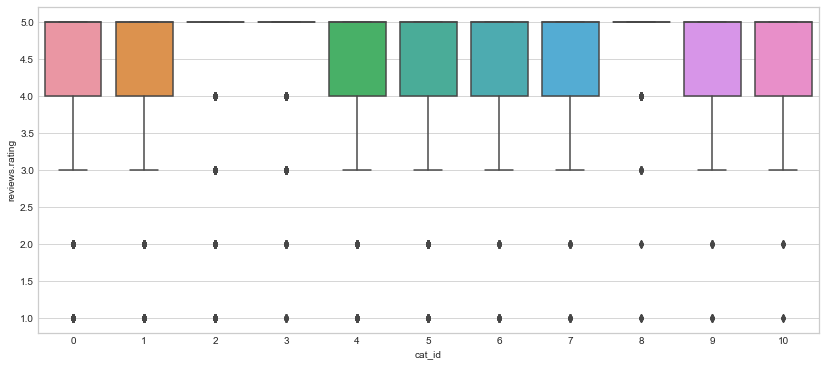

In [220]:
fig,ax = plt.subplots(figsize=(14,6))

fig = sns.boxplot(x = 'cat_id',y='reviews.rating', data = df_cat)

plt.show()

Except category 2,3 & 8, all the other departments’ median rating were 5. <br>
Overall, the ratings are high and sentiment are positive in this review data set. <br>
Category 2,3 & 8 have only 5 ratings without any outlier

## Review Length across Categories

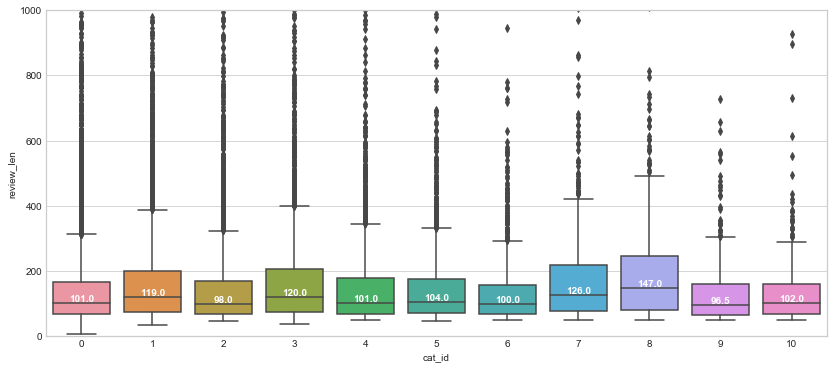

In [221]:

sns.set_style("whitegrid")
fig,ax = plt.subplots(figsize=(14,6))

fig = sns.boxplot(x = 'cat_id',y='review_len', data = df_cat)

#Displaying Median Value
medians = df_cat.groupby(['cat_id'])['review_len'].median()
vertical_offset = df_cat['review_len'].median() * 0.05

for xtick in fig.get_xticks():
    fig.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',color='w',weight='semibold')

plt.ylim(0,1000)

plt.show()

Except category 7 & 8, all have median review length of 100

## Sentiment Score across Categories

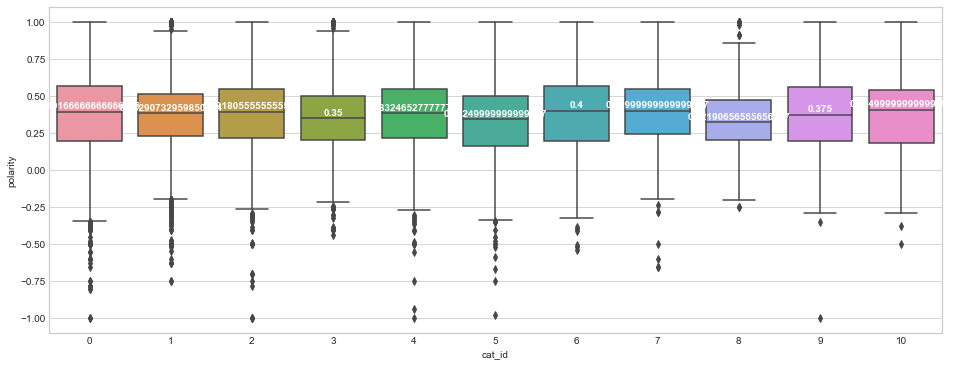

In [232]:
sns.set_style("whitegrid")
fig,ax = plt.subplots(figsize=(16,6))

fig = sns.boxplot(x = 'cat_id',y='polarity', data = df_cat)

medians = df_cat.groupby(['cat_id'])['polarity'].median()
vertical_offset = df_cat['polarity'].median() * 0.05


for xtick in fig.get_xticks():
    fig.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',color='w',weight='semibold')

plt.show()

# Bivariate visualization

## Distribution of sentiment polarity score by recommendations

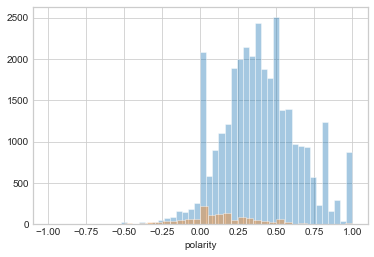

In [237]:
x1 = data.loc[data['reviews.doRecommend']==1,'polarity']
x0 = data.loc[data['reviews.doRecommend']==0,'polarity']

fig, ax = plt.subplots()

for i in [x1,x0]:
    sns.distplot(i, ax=ax, kde=False)
    
plt.show()

## Distribution of review lengths by recommendations


In [243]:
df_revlen = data[data['review_len']<500]

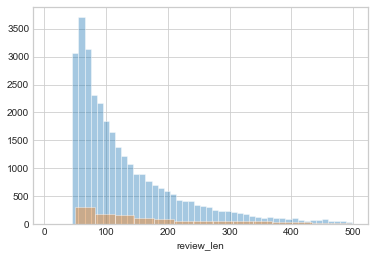

In [247]:
x1 = df_revlen.loc[df_revlen['reviews.doRecommend']==1,'review_len']
x0 = df_revlen.loc[df_revlen['reviews.doRecommend']==0,'review_len']

fig, ax = plt.subplots()

for i in [x1,x0]:
    sns.distplot(i, ax=ax, kde=False)
    
plt.show()

## 2D Density jointplot of sentiment polarity vs. rating

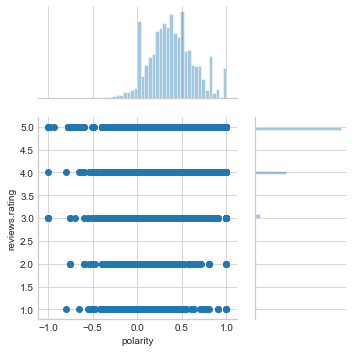

In [253]:
sns.jointplot(data=data, x="polarity", y="reviews.rating",kind='', height=5, ratio=2)

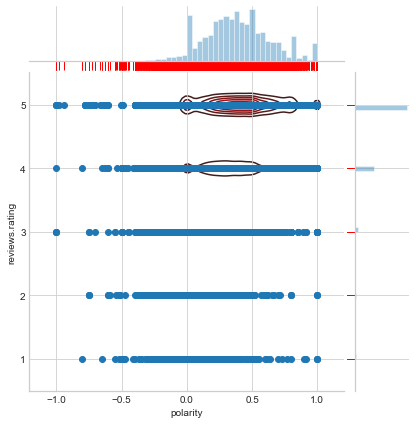

In [256]:
g = sns.jointplot(data=data, x="polarity", y="reviews.rating")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

/Users/tendulkar/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'hue'
  s)


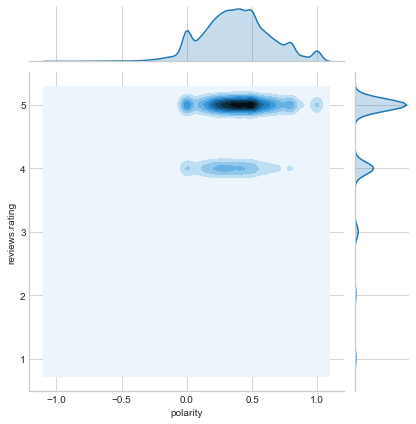

In [257]:
sns.jointplot(data=data, x="polarity", y="reviews.rating",kind='kde', hue='cat_id')

## 2D Density jointplot of sentiment polarity vs. Category

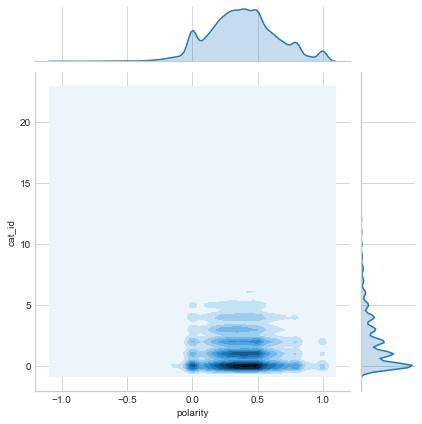

In [258]:
sns.jointplot(data=data, x="polarity", y="cat_id",kind='kde')

# Topic Modeling

## Visualizing sentiments through Scattertext

 Let's analyze words used by different categories and outputs some notable term associations

In [391]:
nlp = spacy.load('en_core_web_sm')

In [393]:
corpus = st.CorpusFromPandas(data, category_col='reviews.doRecommend', text_col='reviews.text', nlp=nlp).build()
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['kindle', 'ipad', 'paperwhite', 'tablet', 'alexa', 'ereader', 'android', 'apps', 'netflix', 'youtube']


In [413]:
corpus.get_term_freq_df()[:10]

,1 freq,0 freq
term,,
this,16350,850
product,3318,166
so,5553,328
far,961,24
has,3846,152
not,9072,1491
disappointed,155,59
my,16336,601
children,430,20


In [427]:
corpus.get_categories()

[1, 0]

**Following are the terms that are mostly associated with reviews that had been reccomended by users to others.** 

In [398]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Recc Score'] = corpus.get_scaled_f_scores(1.0)
print(list(term_freq_df.sort_values(by='Recc Score', ascending=False).index[:10]))

['loves it', 'very easy', 'and easy', 'loves', 'she loves', 'love this', 'great tablet', 'love the', 'love', 'love it']


**Following are the terms that are mostly associated with reviews that had NOT been reccomended by users to others.**

In [410]:
term_freq_df['No Recc Score'] = corpus.get_scaled_f_scores(0.0)
print(list(term_freq_df.sort_values(by='No Recc Score', ascending=False).index[:10]))

['returning', 'returned', 'return', 'i returned', 'to return', 'returned it', 'return it', 'it back', 'not recommend', 'not work']


In [426]:
#sent = st.produce_scattertext_explorer(corpus,category=0,category_name=0,not_category_name='Positive',width_in_pixels=1000)

## LSA

In [265]:
reindexed_data = data['reviews.text']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)


In [281]:
n_topics = 10
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)


In [279]:
#https://gist.github.com/susanli2016/3f88f5aab3f844cc53a44817386d06ce#file-topic_model_lsa-py

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    


def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [282]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

top_n_words_lsa = get_top_n_words(5, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  great tablet use price love
Topic 2:  easy use set love setup
Topic 3:  loves bought gift old christmas
Topic 4:  easy tablet use price good
Topic 5:  great product works loves gift
Topic 6:  love kindle great paperwhite read
Topic 7:  love kids echo alexa music
Topic 8:  product good recommend price excellent
Topic 9:  tv stick cable box amazon
Topic 10:  games old year play kids


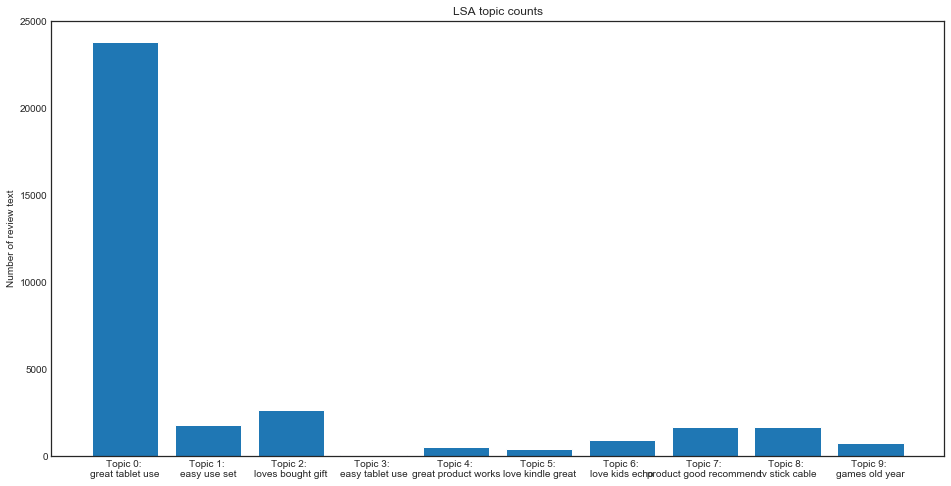

In [283]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts');
plt.show();

# WordCloud

In [434]:
df_grouped=data[['name','reviews.text']].groupby(by='name').agg(lambda x:' '.join(x))
df_grouped.head()

,reviews.text
name,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",this product so far has not disappointed my ch...
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",through all of my research this was the best v...
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,i love this so much i bought two also bought o...
"Amazon - Fire 16GB (5th Gen, 2015 Release) - Black",i love my kindle voyage however it does not ha...
Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,cant beat a tablet for that actually works i ...


In [435]:
cv = CountVectorizer(analyzer='word',stop_words='english')
cv_data = cv.fit_transform(df_grouped['reviews.text'])
df_dtm = pd.DataFrame(cv_data.toarray(),columns=cv.get_feature_names())
df_dtm.index = df_grouped.index
df_dtm.head()

,aa,aaa,aamazon,aand,abandon,abandoned,abandoning,abattery,abc,abcmouse,...,zippy,zombiesotherwise,zone,zones,zoo,zoom,zoomed,zooming,zooms,zwave
name,,,,,,,,,,,,,,,,,,,,,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Amazon - Fire 16GB (5th Gen, 2015 Release) - Black",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [436]:
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()
    
#Transposing document term matrix
df_dtm=df_dtm.transpose()



In [ ]:
# Plotting word cloud for each product. Uncomment
# for index,product in enumerate(df_dtm.columns):
#     generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

## Reading Time

In [326]:
data['text_standard']=data['reviews.text'].apply(lambda x: textstat.text_standard(x))

print('Text Standard of upvoted reviews=>',data[data['reviews.numHelpful']>1]['text_standard'].mode())
print('Text Standard of not upvoted reviews=>',data[data['reviews.numHelpful']<=1]['text_standard'].mode())


Text Standard of upvoted reviews=> 0    5th and 6th grade
dtype: object
Text Standard of not upvoted reviews=> 0    5th and 6th grade
dtype: object


In [327]:
data['reading_time']=data['reviews.text'].apply(lambda x: textstat.reading_time(x))

print('Reading Time of upvoted reviews=>',data[data['reviews.numHelpful']>1]['reading_time'].mean())
print('Reading Time of not upvoted reviews=>',data[data['reviews.numHelpful']<=1]['reading_time'].mean())

Reading Time of upvoted reviews=> 3.8156605351170634
Reading Time of not upvoted reviews=> 1.8079487647560428


The reading time of upvoted reviews is twice that of not upvoted reviews. It means that people usually find longer reviews helpful.